# Heavy Rain - AIFS
---

In the beginning of February 2025, Northern Queensland was hit by extreme rainfall event and large areas of land were flooded. Australia's Bureau of Meteorology reported that the area had received six months of rainfall in three days. <br>

The example shows analysis of the following parameters:
- [`msl`](https://codes.ecmwf.int/grib/param-db/151) mean sea level pressure, and
- [`tp`](https://codes.ecmwf.int/grib/param-db/228228) total precipitation of the **AIFS** datasets on 31 January at 00 UTC in North Queensland (20.77° S, 144.79° E), Australia.

## 1. Set Up Your Environment and Find ECMWF Open Data
Open data will be downloaded from a publicly available [Amazon S3 Bucket](../datadownload/find-data.ipynb). First, the following Python libraries need to be installed in the current Jupyter kernel:
- `ecmwf-opendata` to download data and
- `earthkit` to analyse and plot the data.

:::{seealso}
More detailed information about how to install Python packages is available on the [Retrieve Data](../datadownload/data-download.ipynb) website.
:::
If the packages are not installed yet, uncomment the code below and run it.

In [ ]:
# !pip3 install earthkit ecmwf-opendata

In [1]:
from ecmwf.opendata import Client
import earthkit.data as ekd
import earthkit.plots as ekp

(content:references:listParam)=
### List of parameters to retrieve from open datasets
The selected values below can be modified.
- Parameters available on a single level:

In [111]:
PARAM_SFC = ["msl", "tp"]
LEVELTYPE = "sfc"

DATES = [20250130, 20250131]
TIME = 0
STEPS = 12
STREAM = "oper"
TYPE = "fc"
MODEL = "aifs"

:::{important}
Ensure you specify the model correctly! <br>
Before March 2025, the file-naming convention was different. For more information, visit the [Amazon S3 Buckets](../datadownload/source-aws.ipynb) website.
:::

(content:references:getData)=
### Get the data using the ECMWF Open Data API

In [98]:
def get_open_data(date, time, step, stream, _type, model, param, leveltype, levelist=[]):
    client = Client(source="aws")
    list_of_files = []
    # Get the data for all dates
    for _date in DATES:
        filename = f"{model}_{''.join(param)}_{''.join(map(str, levelist))}_{_date}.grib2" if levelist else f"{model}_{''.join(param)}_{leveltype}_{_date}.grib2"
        data = client.retrieve(
            date=_date,
            time=time,
            step=step,
            stream=stream,
            type=_type,
            levtype=leveltype,
            levelist=levelist,
            param=param,
            model=model,
            target=filename
            )
        list_of_files.append(filename)
    return data, list_of_files

## 2. Total precipitation and mean sea level pressure

In [112]:
data, list_of_files = get_open_data(date=DATES,
                                    time=TIME,
                                    step=STEPS,
                                    stream=STREAM,
                                    _type=TYPE,
                                    model=MODEL,
                                    param=PARAM_SFC,
                                    leveltype=LEVELTYPE,
                                    levelist=[])

# Select AIFS model data from 31 January 2025
ds = ekd.from_source("file", list_of_files[1])
ds.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,tp,surface,0,20250131,0,0-12,fc,None,regular_ll
1,ecmf,msl,meanSea,0,20250131,0,12,fc,None,regular_ll


When using the `head()` method, a selected number of rows `n` and information about the fields in the file we downloaded will be displayed.

In [113]:
ds.head(n=2, namespace="parameter")

,centre,paramId,shortName,units,name
0,ecmf,228,tp,m,Total precipitation
1,ecmf,151,msl,Pa,Mean sea level pressure


:::{tip}
See further examples of how to [inspect content of the GRIB data](https://earthkit-data.readthedocs.io/en/latest/examples/grib_metadata.html).
:::

In the [ECMWF Open Charts](https://charts.ecmwf.int/), total precipitation is plotted in millimetres. Therefore, our result also need to be multiplied by 1000.

In [114]:
tp3101 = ds.sel(shortName="tp")
md_tp3101 = tp3101.metadata()

tp3101_mm = tp3101.values * 1000
tp_3101 = ekd.FieldList.from_array(tp3101_mm, md_tp3101)
tp_3101.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,tp,surface,0,20250131,0,0-12,fc,None,regular_ll


We will plot mean sea level pressure data in hPa, therefore we need to divide them by 100.

In [115]:
msl = ds.sel(shortName="msl")
md_msl = msl.metadata()

msl_hPa = msl.values / 100
msl_3101 = ekd.FieldList.from_array(msl_hPa, md_msl)
msl_3101.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,msl,meanSea,0,20250131,0,12,fc,None,regular_ll


## 3. Total precipitation

The input values can be set [here](#content:references:listParam).

In [78]:
PARAM_SFC = "tp"
LEVELS = []
LEVELTYPE = "sfc"

DATES = 20250130
TIME = 0
STEPS = [12, 24, 36, 48, 60, 72, 84, 96]
STREAM = "oper"
TYPE = "fc"
MODEL = "aifs"

The function below is similar to the [one defined above](#content:references:getData).

In [87]:
filename = f"{MODEL}_{PARAM_SFC}_{DATES}_{'-'.join(map(str, STEPS))}.grib2"

def get_open_data_Nsteps(filename, date, time, step, stream, _type, model, param, leveltype, levelist=[]):
    client = Client(source="aws")
    # Get the data for all steps
    data = client.retrieve(
        date=date,
        time=time,
        step=step,
        stream=stream,
        type=_type,
        levtype=leveltype,
        levelist=levelist,
        param=param,
        model=model,
        target=filename
        )
    return data

In [88]:
data = get_open_data_Nsteps(filename,
                            date=DATES,
                            time=TIME,
                            step=STEPS,
                            stream=STREAM,
                            _type=TYPE,
                            model=MODEL,
                            param=PARAM_SFC,
                            leveltype=LEVELTYPE,
                            levelist=[])

ds_tp = ekd.from_source("file", filename)
ds_tp.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,tp,surface,0,20250130,0,0-12,fc,None,regular_ll
1,ecmf,tp,surface,0,20250130,0,0-24,fc,None,regular_ll
2,ecmf,tp,surface,0,20250130,0,0-36,fc,None,regular_ll
3,ecmf,tp,surface,0,20250130,0,0-48,fc,None,regular_ll
4,ecmf,tp,surface,0,20250130,0,0-60,fc,None,regular_ll
5,ecmf,tp,surface,0,20250130,0,0-72,fc,None,regular_ll
6,ecmf,tp,surface,0,20250130,0,0-84,fc,None,regular_ll
7,ecmf,tp,surface,0,20250130,0,0-96,fc,None,regular_ll


The `tp` parameter gives information about total accumulated rainfall from the start of the forecast onwards. For instance, `step=12` indicates accumulated precipitation from 00 UTC until 12 UTC, `step=96` from 00 UTC up to 4 days ahead.

In [85]:
md_tp = ds_tp.metadata()

tp_mm = ds_tp.values * 1000
tp = ekd.FieldList.from_array(tp_mm, md_tp)
tp.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,tp,surface,0,20250130,0,0-12,fc,None,regular_ll
1,ecmf,tp,surface,0,20250130,0,0-24,fc,None,regular_ll
2,ecmf,tp,surface,0,20250130,0,0-36,fc,None,regular_ll
3,ecmf,tp,surface,0,20250130,0,0-48,fc,None,regular_ll
4,ecmf,tp,surface,0,20250130,0,0-60,fc,None,regular_ll
5,ecmf,tp,surface,0,20250130,0,0-72,fc,None,regular_ll
6,ecmf,tp,surface,0,20250130,0,0-84,fc,None,regular_ll
7,ecmf,tp,surface,0,20250130,0,0-96,fc,None,regular_ll


## 4. Data visualisation

The plot below shows analysis of mean sea level pressure and total precipitation on 31 January 2025.

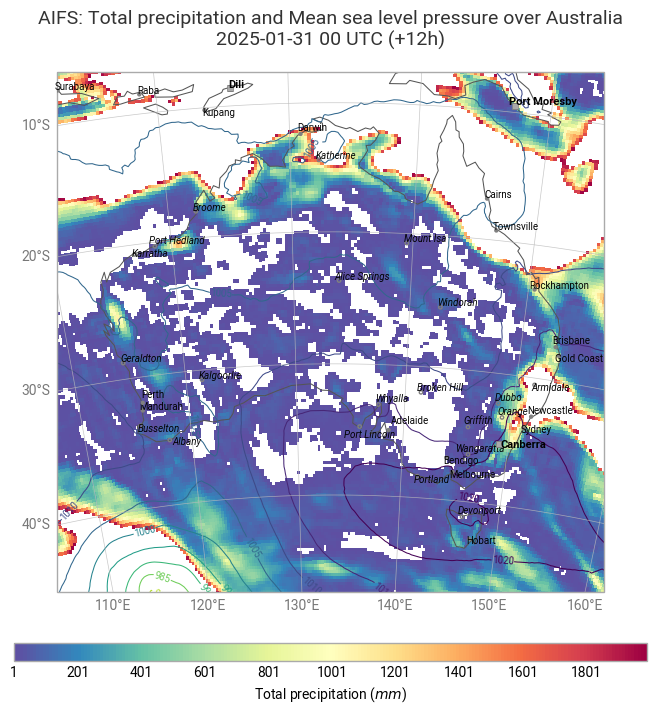

In [119]:
chart = ekp.Map(domain="Australia")

tp3101_style = ekp.styles.Style(
    colors="Spectral_r",
    levels=range(1, 2000, 10),
    units="mm",
)

chart.grid_cells(tp_3101, style=tp3101_style)
chart.contour(msl_3101, legend_style="None")

chart.coastlines(resolution="low")
chart.gridlines()
chart.cities(adjust_labels=True)

chart.legend(location="bottom", label="{variable_name} ({units})")

chart.title(
    "AIFS: {variable_name} over {domain}\n"
    "{base_time:%Y-%m-%d %H} UTC (+{lead_time}h)\n",
    fontsize=14, horizontalalignment="center",
)
chart.save(f"./plots/{''.join(PARAM_SFC)}_{MODEL}_{DATES[1]}{TIME}-{STEPS}h.png")
chart.show()

The plots below show analyses of total precipitation from 30 January at 00 UTC to 3 February, every 12 hours.

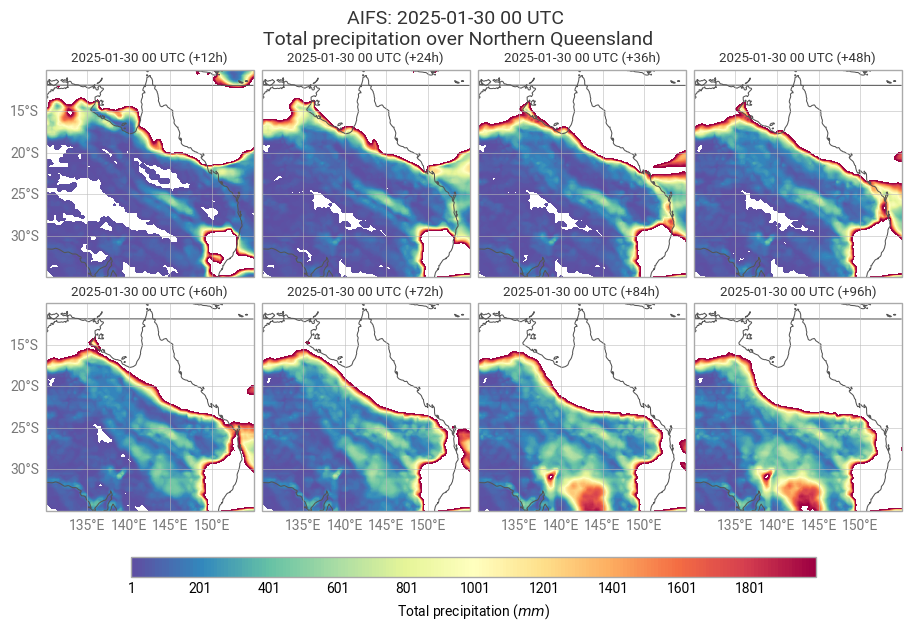

In [83]:
figure = ekp.Figure(domain=[130, 155, -35, -10], size=(9, 8), rows=3, columns=4)

tp_style = ekp.styles.Style(
    colors="Spectral_r",
    levels=range(1, 2000, 10),
    units="mm",
)

for i in range(8):
    figure.add_map(1+i//4, i%4)

figure.contourf(tp, style=tp_style)

figure.coastlines()
figure.gridlines()

figure.legend(label="{variable_name} ({units})")

figure.subplot_titles("{base_time:%Y-%m-%d %H} UTC (+{lead_time}h)")
figure.title(
    "AIFS: {base_time:%Y-%m-%d %H} UTC\n {variable_name} over Northern Queensland\n\n",
    fontsize=14, horizontalalignment="center",
)
figure.save(fname=f"./plots/{PARAM_SFC}_{MODEL}_{DATES}{TIME}-{'-'.join(map(str, STEPS))}h.png")
figure.show()

Since 31 January 2025, total accumulated rainfall has broken multiple records across north Queensland. Record-crushing level of rain was observed in the coastal area north from Townsville.